# DataFrame

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

In [2]:
df = pd.read_csv("smoke_detection_cleaned.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Temperature[C]     62630 non-null  float64
 1   Humidity[%]        62630 non-null  float64
 2   TVOC[ppb]          62630 non-null  float64
 3   eCO2[ppm]          62630 non-null  float64
 4   Raw H2             62630 non-null  float64
 5   Raw Ethanol        62630 non-null  float64
 6   Pressure[hPa]      62630 non-null  float64
 7   PM1.0              62630 non-null  float64
 8   NC0.5              62630 non-null  float64
 9   Fire Alarm         62630 non-null  int64  
 10  Temp_Category      50605 non-null  object 
 11  Humidity_Category  62630 non-null  object 
dtypes: float64(9), int64(1), object(2)
memory usage: 5.7+ MB


In [3]:
df.head()

,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,NC0.5,Fire Alarm,Temp_Category,Humidity_Category
0,0.280622,0.994947,-0.248614,-0.141679,-2.335935,-2.025006,0.831761,-0.109043,-0.115215,0,Moderate,High
1,0.281666,0.917115,-0.248614,-0.141679,-2.192796,-1.810079,0.838521,-0.109043,-0.115215,0,Moderate,High
2,0.282641,0.837028,-0.248614,-0.141679,-2.086359,-1.624683,0.834014,-0.109043,-0.115215,0,Moderate,High
3,0.283686,0.760324,-0.248614,-0.141679,-2.027636,-1.485227,0.832512,-0.109043,-0.115215,0,Moderate,High
4,0.284730,0.693773,-0.248614,-0.141679,-1.979923,-1.367099,0.838521,-0.109043,-0.115215,0,Moderate,High


In [4]:
df = df.drop(axis=1, columns=['Temp_Category', 'Humidity_Category'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature[C]  62630 non-null  float64
 1   Humidity[%]     62630 non-null  float64
 2   TVOC[ppb]       62630 non-null  float64
 3   eCO2[ppm]       62630 non-null  float64
 4   Raw H2          62630 non-null  float64
 5   Raw Ethanol     62630 non-null  float64
 6   Pressure[hPa]   62630 non-null  float64
 7   PM1.0           62630 non-null  float64
 8   NC0.5           62630 non-null  float64
 9   Fire Alarm      62630 non-null  int64  
dtypes: float64(9), int64(1)
memory usage: 4.8 MB


# Search Algorithm

In [5]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from joblib import Parallel, delayed
import joblib

In [6]:
X = df.drop('Fire Alarm', axis=1)
y = df['Fire Alarm']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
param_grids = {
    "Random Forest": {
        "model__n_estimators": [50, 100, 200, 500],
        "model__max_depth": [None, 5, 10, 20],
        "model__min_samples_split": [2, 5, 10],
    },
    "Gradient Boosting": {
        "model__n_estimators": [50, 100, 200],
        "model__learning_rate": [0.001, 0.01, 0.1, 0.2],
        "model__max_depth": [3, 5, 10]
    },
    "KNN": {
        "model__n_neighbors": list(range(3, 21)),
        "model__weights": ["uniform", "distance"]
    },
    "Logistic Regression": {
        "model__C": [0.01, 0.1, 1, 10, 100],
        "model__penalty": ["l1", "l2", "elasticnet", None],
        "model__solver": ["saga", "lbfgs"],
        "model__max_iter": [500, 1000, 1500]
    }
}

models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=1500)
}

In [8]:
def save_classification_report(y_true, y_pred, model_name, save_path="reports"):
    """Generate and save classification report as a text file."""
    os.makedirs(save_path, exist_ok=True)
    report = classification_report(y_true, y_pred)
    file_path = f"{save_path}/{model_name.replace(' ', '_')}_classification_report.txt"
    with open(file_path, "w") as f:
        f.write(f"===== Classification Report: {model_name} =====\n\n")
        f.write(report)
    print(f"📄 Classification report saved to {file_path}")


def save_confusion_matrix(y_true, y_pred, model_name, save_path="reports"):
    """Generate and save confusion matrix as PNG."""
    os.makedirs(save_path, exist_ok=True)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    file_path = f"{save_path}/{model_name.replace(' ', '_')}_confusion_matrix.png"
    plt.savefig(file_path)
    plt.close()
    print(f"🖼️ Confusion matrix saved to {file_path}")

In [9]:
def tune_model(name, model, params, X_train, y_train, X_test, y_test, save_path="models"):
    """Function to run RandomizedSearchCV for a given model."""

    pipe = Pipeline([
        ("model", model)
    ])

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=params,
        n_iter=10,
        scoring="f1_weighted",
        n_jobs=-1,
        cv=3,
        random_state=42
    )

    search.fit(X_train, y_train)
    best_model = search.best_estimator_

    # Save best model
    os.makedirs(save_path, exist_ok=True)
    model_file = f"{save_path}/{name.replace(' ', '_')}_best.pkl"
    joblib.dump(best_model, model_file)

    # Evaluate
    y_pred = best_model.predict(X_test)
    score = f1_score(y_test, y_pred, average="weighted")

    # Save reports
    save_classification_report(y_test, y_pred, name)
    save_confusion_matrix(y_test, y_pred, name)

    return {
        "Model": name,
        "Best Params": search.best_params_,
        "Best CV Score": search.best_score_,
        "Test F1 Score": score,
        "Model File": model_file
    }



# ========== Run All Models in Parallel ==========

results = Parallel(n_jobs=-1, verbose=10)(
    delayed(tune_model)(name, model, param_grids[name], X_train, y_train, X_test, y_test)
    for name, model in models.items()
)

# Summary dataframe
results_df = pd.DataFrame(results).sort_values(by="Test F1 Score", ascending=False)
results_df.to_csv("search_summary.csv", index=False)

print("✅ Done! Summary saved to search_summary.csv, models in /models, reports in /reports.")
print(results_df)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:  2.5min remaining:  2.5min


✅ Done! Summary saved to search_summary.csv, models in /models, reports in /reports.
                 Model                                        Best Params  \
0        Random Forest  {'model__n_estimators': 500, 'model__min_sampl...   
1    Gradient Boosting  {'model__n_estimators': 100, 'model__max_depth...   
2                  KNN  {'model__weights': 'distance', 'model__n_neigh...   
3  Logistic Regression  {'model__solver': 'saga', 'model__penalty': 'l...   

   Best CV Score  Test F1 Score                           Model File  
0       0.999860       1.000000        models/Random_Forest_best.pkl  
1       0.999740       1.000000    models/Gradient_Boosting_best.pkl  
2       0.997824       0.997604                  models/KNN_best.pkl  
3       0.893382       0.892053  models/Logistic_Regression_best.pkl  


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:  3.0min finished


# Results

In [12]:
results_df = pd.read_csv("search_summary.csv")
results_df

,Model,Best Params,Best CV Score,Test F1 Score,Model File
0,Random Forest,"{'model__n_estimators': 500, 'model__min_sampl...",0.999840,1.000000,models/Random_Forest_best.pkl
1,Gradient Boosting,"{'model__n_estimators': 100, 'model__max_depth...",0.999740,1.000000,models/Gradient_Boosting_best.pkl
2,KNN,"{'model__weights': 'distance', 'model__n_neigh...",0.997824,0.997604,models/KNN_best.pkl
3,Logistic Regression,"{'model__solver': 'saga', 'model__penalty': 'l...",0.893382,0.892053,models/Logistic_Regression_best.pkl


<Figure size 1000x600 with 0 Axes>

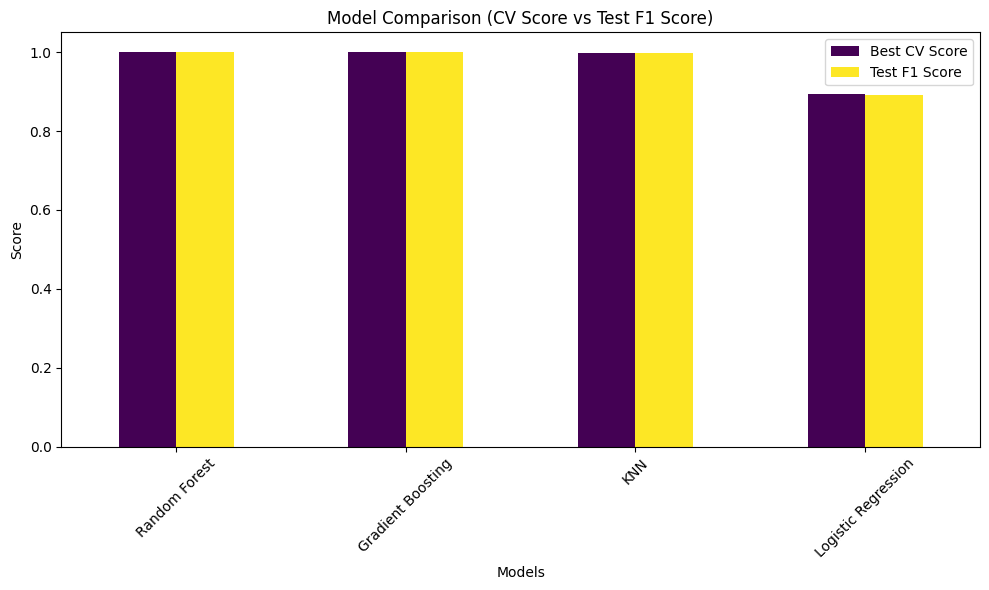

In [13]:
df_plot = results_df.set_index("Model")

plt.figure(figsize=(10, 6))
df_plot[["Best CV Score", "Test F1 Score"]].plot(
    kind="bar",
    figsize=(10, 6),
    colormap="viridis"
)

plt.title("Model Comparison (CV Score vs Test F1 Score)")
plt.ylabel("Score")
plt.xlabel("Models")
plt.xticks(rotation=45)
plt.legend(["Best CV Score", "Test F1 Score"])
plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

# Loading best Model

In [11]:
import joblib

# Load model
#best_model = joblib.load("models/Random_Forest_best.pkl")